In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd # For loading tract geometries and spatial operations
import rasterio # For reading raster properties (used by rasterstats)
from rasterio.mask import mask
from rasterstats import zonal_stats # For zonal statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf # For formula-based regression
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np 

# Optional: to make plots appear inline in Jupyter
%matplotlib inline

# Optional: settings to display all columns in pandas
pd.set_option('display.max_columns', None)
print("Modeling and geospatial libraries imported.")

Modeling and geospatial libraries imported.


In [3]:
# Cell 2: Load Cleaned ACS Data

acs_data_path = r'../uhi-analysis/final/wy_laramie_acs_ALLYEARS_tract_data_cleaned.csv'
try:
    acs_df = pd.read_csv(acs_data_path, dtype={'GEOID': str})
    print("ACS data loaded successfully.")
    print(f"ACS DataFrame shape: {acs_df.shape}")
    
    if 'year' not in acs_df.columns:
        print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("CRITICAL WARNING: The loaded ACS data ('wy_laramie_acs_ALLYEARS_tract_data_cleaned.csv') does NOT have a 'year' column!")
        print("Please ensure your ACS multi-year processing correctly added and saved a 'year' column.")
        print("Cannot proceed with multi-year merging without it. Subsequent cells will likely fail.")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
    else:
        print("\n'year' column found in ACS data.")
        acs_df['year'] = acs_df['year'].astype(int) # Ensure year is integer
        print(f"ACS years range: {acs_df['year'].min()} - {acs_df['year'].max()}")
        print("Sample of ACS data (GEOID and year):")
        print(acs_df[['GEOID', 'year']].head())

    # print("\nFull ACS data head:")
    # print(acs_df.head())

except FileNotFoundError:
    print(f"Error: ACS data file not found at {acs_data_path}")
    acs_df = pd.DataFrame() 
except Exception as e:
    print(f"An error occurred loading the ACS data: {e}")
    acs_df = pd.DataFrame()

ACS data loaded successfully.
ACS DataFrame shape: (228, 12)

'year' column found in ACS data.
ACS years range: 2013 - 2022
Sample of ACS data (GEOID and year):
         GEOID  year
0  56021002000  2013
1  56021000600  2013
2  56021000700  2013
3  56021000800  2013
4  56021001000  2013


In [4]:
# Cell 3: Load Geospatial Data and Prepare for LST/NDVI Integration


print("Cell 2: Starting - Loading ACS Data, Geospatial Data, and Preparing for LST/NDVI Integration")

# --- BEGINNING OF COPIED/ADAPTED LOGIC FROM CELL 1 ---
# Load the cleaned multi-year ACS data
acs_data_path = r"../uhi-analysis/final/wy_laramie_acs_ALLYEARS_tract_data_cleaned.csv"
acs_data = pd.DataFrame() # Initialize
min_acs_year, max_acs_year = 0, 0 # Initialize
acs_years_range = (0,0) # Initialize

try:
    acs_data = pd.read_csv(acs_data_path)
    print(f"ACS data loaded successfully from: {acs_data_path}")
    print(f"ACS DataFrame shape: {acs_data.shape}")

    if 'year' in acs_data.columns and not acs_data['year'].empty:
        min_acs_year = acs_data['year'].min()
        max_acs_year = acs_data['year'].max()
        acs_years_range = (min_acs_year, max_acs_year)
        print(f"'year' column found in ACS data. ACS years range: {min_acs_year} - {max_acs_year}")
        # print("Sample of ACS data (GEOID and year):")
        # print(acs_data[['GEOID', 'year']].head()) # Already confirmed this works
    else:
        print("ERROR: 'year' column not found or empty in ACS data. Cannot determine year range.")
        print("Please check the CSV file structure and content.")
        # acs_years_range remains (0,0) which will affect LST filtering

    if 'GEOID' not in acs_data.columns:
        print("ERROR: 'GEOID' column not found in ACS data. This is critical for merging.")
    else:
        # Ensure GEOID is string for merging
        acs_data['GEOID'] = acs_data['GEOID'].astype(str)

except FileNotFoundError:
    print(f"CRITICAL ERROR: ACS data file not found at {acs_data_path}")
    print("Cannot proceed without ACS data.")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load ACS data from {acs_data_path}. Error: {e}")
    print("Cannot proceed without ACS data.")
# --- END OF COPIED/ADAPTED LOGIC FROM CELL 1 ---


# --- 1. Load Wyoming Census Tracts Shapefile ---
shapefile_path = r"../uhi-analysis/tl_2024_56_tract/tl_2024_56_tract.shp" # YOUR PATH
gdf_laramie_tracts = gpd.GeoDataFrame() 
try:
    gdf_wy_tracts = gpd.read_file(shapefile_path)
    print(f"Wyoming tracts shapefile loaded successfully. Shape: {gdf_wy_tracts.shape}")
    
    if 'GEOID' not in gdf_wy_tracts.columns:
        if 'GEOIDFP' in gdf_wy_tracts.columns:
             gdf_wy_tracts.rename(columns={'GEOIDFP': 'GEOID'}, inplace=True)
        elif 'STATEFP' in gdf_wy_tracts.columns and 'COUNTYFP' in gdf_wy_tracts.columns and 'TRACTCE' in gdf_wy_tracts.columns:
            gdf_wy_tracts['GEOID'] = gdf_wy_tracts['STATEFP'] + gdf_wy_tracts['COUNTYFP'] + gdf_wy_tracts['TRACTCE']
        else:
            print("ERROR: Shapefile does not have a clear GEOID column. Please inspect shapefile attributes.")
            gdf_wy_tracts['GEOID'] = "MISSING_GEOID_DATA" 

    gdf_wy_tracts['GEOID'] = gdf_wy_tracts['GEOID'].astype(str)
    # print("Sample of tracts GeoDataFrame (GEOID and geometry):")
    # print(gdf_wy_tracts[['GEOID', 'geometry']].head())

    laramie_county_fips = '021'
    state_fips = '56' 
    
    if 'COUNTYFP' in gdf_wy_tracts.columns and 'STATEFP' in gdf_wy_tracts.columns:
        gdf_laramie_tracts = gdf_wy_tracts[
            (gdf_wy_tracts['COUNTYFP'] == laramie_county_fips) & 
            (gdf_wy_tracts['STATEFP'] == state_fips)
        ].copy() 
        if gdf_laramie_tracts.empty:
            print(f"Warning: No tracts found for Laramie County (FIPS {state_fips}{laramie_county_fips}). Using all WY tracts.")
            gdf_laramie_tracts = gdf_wy_tracts.copy()
        else:
            print(f"Filtered for Laramie County. Shape: {gdf_laramie_tracts.shape}")
    else:
        print("Warning: 'COUNTYFP' or 'STATEFP' column not found. Using all Wyoming tracts.")
        gdf_laramie_tracts = gdf_wy_tracts.copy()

    # print(f"Tracts CRS: {gdf_laramie_tracts.crs}")

except Exception as e:
    print(f"Error loading or processing shapefile: {e}")

# --- 2. Load NDVI/LST Timeseries CSV ---
ndvi_lst_csv_path = r"../uhi-analysis/NDVI_LST_Timeseries.csv" # YOUR PATH
df_ndvi_lst_agg = pd.DataFrame() 
try:
    df_ndvi_lst_agg = pd.read_csv(ndvi_lst_csv_path)
    print(f"\nNDVI_LST_Timeseries.csv loaded successfully. Shape: {df_ndvi_lst_agg.shape}")
    # print("Sample of NDVI/LST aggregated data:")
    # print(df_ndvi_lst_agg.head())
    if 'Year' in df_ndvi_lst_agg.columns:
        df_ndvi_lst_agg['Year'] = df_ndvi_lst_agg['Year'].astype(int)
    else:
        print("ERROR: 'Year' column not found in NDVI_LST_Timeseries.csv")
except Exception as e:
    print(f"Error loading NDVI_LST_Timeseries.csv: {e}")

# --- 3. Prepare for LST Data from GeoTIFFs ---
lst_tiff_directory = r"../uhi-analysis/gee_exports/" # YOUR PATH
available_lst_years = []
lst_tiff_files = {} 

if os.path.exists(lst_tiff_directory) and acs_years_range != (0,0) : # Check if ACS data loaded for range
    print(f"\nLooking for LST GeoTIFFs in: {lst_tiff_directory}")
    for filename in os.listdir(lst_tiff_directory):
        if filename.lower().endswith((".tif", ".tiff")):
            try:
                parts = filename.split('_')
                if len(parts) >= 3: 
                    year_str_with_ext = parts[2] 
                    year_str = year_str_with_ext.split('.')[0]
                    year = int(year_str)
                    
                    if acs_years_range[0] <= year <= acs_years_range[1]: # Filter by ACS year range
                        available_lst_years.append(year)
                        lst_tiff_files[year] = os.path.join(lst_tiff_directory, filename)
                        print(f"  Found and queued LST TIFF: {filename} for year {year}")
                    else:
                        print(f"  LST TIFF found for year {year} ({filename}), but it's outside the ACS data range {acs_years_range}. Skipping.")
                else:
                    print(f"  Filename '{filename}' does not match expected format (e.g., Prefix_Descriptor_YEAR.tif). Skipping.")
            except (IndexError, ValueError) as e_parse:
                print(f"  Could not parse year from LST TIFF filename: {filename}. Error: {e_parse}. Skipping this file.")
    
    available_lst_years = sorted(list(set(available_lst_years)))
    if available_lst_years:
        print(f"Successfully processed LST GeoTIFFs for years: {available_lst_years}")
        missing_lst_for_acs_years = set(range(acs_years_range[0], acs_years_range[1] + 1)) - set(available_lst_years)
        if missing_lst_for_acs_years:
            print(f"Warning: Based on ACS range {acs_years_range}, missing LST TIFFs for years: {sorted(list(missing_lst_for_acs_years))}")
    else: 
        print(f"No LST GeoTIFFs found matching the ACS years ({acs_years_range[0]}-{acs_years_range[1]}) in {lst_tiff_directory}")

elif not os.path.exists(lst_tiff_directory):
    print(f"ERROR: LST GeoTIFF directory not found: {lst_tiff_directory}")
elif acs_years_range == (0,0):
    print("ERROR: ACS year range not determined (likely ACS data failed to load). Cannot filter LST TIFFs by year.")
    print(f"Please check ACS data loading at the beginning of this cell and the path: {acs_data_path}")


print("\nCell 3: Finished.")

Cell 2: Starting - Loading ACS Data, Geospatial Data, and Preparing for LST/NDVI Integration
ACS data loaded successfully from: ../uhi-analysis/final/wy_laramie_acs_ALLYEARS_tract_data_cleaned.csv
ACS DataFrame shape: (228, 12)
'year' column found in ACS data. ACS years range: 2013 - 2022
Wyoming tracts shapefile loaded successfully. Shape: (160, 14)
Filtered for Laramie County. Shape: (27, 14)

NDVI_LST_Timeseries.csv loaded successfully. Shape: (12, 3)

Looking for LST GeoTIFFs in: ../uhi-analysis/gee_exports/
  Found and queued LST TIFF: NDVI_LST_2013.tif for year 2013
  Found and queued LST TIFF: NDVI_LST_2014.tif for year 2014
  Found and queued LST TIFF: NDVI_LST_2015.tif for year 2015
  Found and queued LST TIFF: NDVI_LST_2016.tif for year 2016
  Found and queued LST TIFF: NDVI_LST_2017.tif for year 2017
  Found and queued LST TIFF: NDVI_LST_2018.tif for year 2018
  Found and queued LST TIFF: NDVI_LST_2019.tif for year 2019
  Found and queued LST TIFF: NDVI_LST_2020.tif for year

In [5]:
# Cell 4: Zonal Statistics - Extract Mean LST per Tract per Year

from shapely.geometry import mapping # For converting GeoPandas geometry to GeoJSON-like dict

print("Cell 4: Starting Zonal Statistics - Extracting Mean LST per Tract per Year.")

# Ensure necessary variables from Cell 2 are available
if 'gdf_laramie_tracts' not in locals() or gdf_laramie_tracts.empty:
    print("ERROR: gdf_laramie_tracts (Laramie County tracts GeoDataFrame) not found or empty.")
    print("Please ensure Cell 2 was run successfully.")
    # Create a dummy to prevent immediate crash, but cell won't work
    gdf_laramie_tracts = gpd.GeoDataFrame() 
if 'lst_tiff_files' not in locals() or not lst_tiff_files:
    print("ERROR: lst_tiff_files (dictionary of LST GeoTIFFs) not found or empty.")
    print("Please ensure Cell 2 was run successfully and found LST TIFFs.")
    lst_tiff_files = {}
if 'acs_data' not in locals() or acs_data.empty:
    print("ERROR: acs_data DataFrame not found or empty. Needed for final merge.")
    # Create a dummy to prevent immediate crash, but cell won't work
    acs_data = pd.DataFrame()


# List to store results: each item will be a dictionary {GEOID, year, mean_LST}
zonal_stats_results = []
processed_years_count = 0

# Check if there are tracts and LST files to process
if not gdf_laramie_tracts.empty and lst_tiff_files:
    # Sort years to process them in order, though not strictly necessary
    sorted_lst_years = sorted(lst_tiff_files.keys())

    for year in sorted_lst_years:
        lst_filepath = lst_tiff_files[year]
        print(f"\nProcessing LST for Year: {year} from file: {lst_filepath}")
        
        try:
            with rasterio.open(lst_filepath) as src_raster:
                raster_crs = src_raster.crs
                raster_transform = src_raster.transform
                
                # Ensure tracts are in the same CRS as the raster for accurate zonal stats
                # It's generally better to reproject vector to raster CRS for zonal stats
                if gdf_laramie_tracts.crs != raster_crs:
                    print(f"  Tracts CRS ({gdf_laramie_tracts.crs}) differs from LST raster CRS ({raster_crs}). Reprojecting tracts for year {year}...")
                    gdf_tracts_reprojected = gdf_laramie_tracts.to_crs(raster_crs)
                else:
                    gdf_tracts_reprojected = gdf_laramie_tracts.copy() # Use a copy if no reprojection needed

                print(f"  Extracting LST for {len(gdf_tracts_reprojected)} tracts...")
                tract_count_for_year = 0
                for index, tract_row in gdf_tracts_reprojected.iterrows():
                    geoid = tract_row['GEOID']
                    geometry = tract_row['geometry']
                    
                    # Ensure geometry is valid
                    if not geometry.is_valid:
                        print(f"    Warning: Invalid geometry for GEOID {geoid}. Attempting to buffer by 0 to fix.")
                        geometry = geometry.buffer(0)
                        if not geometry.is_valid:
                            print(f"    ERROR: Geometry for GEOID {geoid} could not be fixed. Skipping tract for year {year}.")
                            continue # Skip this tract for this year

                    try:
                        # Convert GeoPandas geometry to GeoJSON-like mapping for rasterio.mask
                        geo_json_geometry = [mapping(geometry)]
                        
                        # Mask the raster with the tract geometry
                        # out_image is a NumPy array, out_transform is the affine transform of the subset
                        out_image, out_transform = mask(src_raster, geo_json_geometry, crop=True, nodata=np.nan)
                        
                        # Remove the first dimension if it's 1 (typical for single-band rasters)
                        if out_image.ndim == 3 and out_image.shape[0] == 1:
                            out_image = out_image.squeeze(axis=0)

                        # Calculate mean LST, ignoring NaN values (nodata)
                        # Check if there are any valid pixels after masking
                        if np.all(np.isnan(out_image)) or out_image.size == 0:
                            mean_lst_for_tract = np.nan # No valid data pixels
                            # print(f"    No valid LST data for GEOID {geoid} in year {year} after masking.")
                        else:
                            mean_lst_for_tract = np.nanmean(out_image)
                        
                        zonal_stats_results.append({
                            'GEOID': geoid,
                            'year': year,
                            'mean_LST': mean_lst_for_tract
                        })
                        tract_count_for_year += 1

                    except Exception as e_mask:
                        print(f"    Error during masking/stats for GEOID {geoid}, Year {year}: {e_mask}")
                        zonal_stats_results.append({
                            'GEOID': geoid,
                            'year': year,
                            'mean_LST': np.nan # Record as NaN on error
                        })
                print(f"  Successfully processed {tract_count_for_year} tracts for LST in {year}.")
            processed_years_count +=1

        except Exception as e_raster:
            print(f"  ERROR opening or processing LST raster for Year {year} ({lst_filepath}): {e_raster}")
            # If a whole year's raster fails, we might want to add NaNs for all tracts for that year
            for index, tract_row in gdf_laramie_tracts.iterrows():
                 zonal_stats_results.append({
                    'GEOID': tract_row['GEOID'],
                    'year': year,
                    'mean_LST': np.nan
                })


    print(f"\nFinished LST extraction for {processed_years_count} year(s).")

    # --- Convert results to DataFrame ---
    if zonal_stats_results:
        df_lst = pd.DataFrame(zonal_stats_results)
        print("\n--- Sample of Extracted LST Data ---")
        print(df_lst.head())
        print(f"\nShape of LST DataFrame: {df_lst.shape}")
        print("\n--- LST DataFrame Info ---")
        df_lst.info()
        
        # Check for NaNs in LST data
        nan_lst_counts = df_lst['mean_LST'].isna().sum()
        print(f"\nNumber of NaN LST values: {nan_lst_counts} out of {len(df_lst)}")
        if nan_lst_counts > 0:
            print("  (NaNs can occur if tracts are outside raster extent, raster has no-data over tract, or errors during processing)")

        # --- Merge LST data with acs_data ---
        if not acs_data.empty:
            print("\nMerging LST data with ACS data...")
            # Ensure GEOID and year are correct types for merging
            acs_data['GEOID'] = acs_data['GEOID'].astype(str)
            acs_data['year'] = acs_data['year'].astype(int)
            df_lst['GEOID'] = df_lst['GEOID'].astype(str)
            df_lst['year'] = df_lst['year'].astype(int)

            # Perform the merge
            # Keep all ACS data rows, and add LST where available
            final_merged_df = pd.merge(acs_data, df_lst, on=['GEOID', 'year'], how='left')
            
            print(f"Shape of merged DataFrame: {final_merged_df.shape}")
            print("\n--- Sample of Final Merged DataFrame (with LST) ---")
            print(final_merged_df[['GEOID', 'year', 'Total_Population', 'Median_Household_Income', 'Poverty_Rate', 'Vacancy_Rate', 'mean_LST']].head())
            print("\n--- Info of Final Merged DataFrame ---")
            final_merged_df.info()
            
            # Check LST column in merged data
            nan_in_merged_lst = final_merged_df['mean_LST'].isna().sum()
            print(f"\nNumber of NaN LST values in final merged DataFrame: {nan_in_merged_lst}")

            # Assign to a well-known variable name for the next cell
            df_analysis = final_merged_df.copy()
            print("\nAssigned merged data to 'df_analysis'.")
            
        else:
            print("acs_data is empty. Cannot merge LST data. LST data is in 'df_lst'.")
            df_analysis = df_lst.copy() # Fallback if no ACS data
            print("Assigned LST data (no ACS merge) to 'df_analysis'.")

    else:
        print("No zonal statistics results were generated.")
        df_analysis = acs_data.copy() # Fallback if no LST processing
        print("Assigned original 'acs_data' to 'df_analysis' as no LST was processed.")

else:
    if gdf_laramie_tracts.empty :
        print("Skipping LST extraction because Laramie tracts GeoDataFrame is empty.")
    if not lst_tiff_files:
        print("Skipping LST extraction because no LST TIFF files were found/queued in Cell 2.")
    df_analysis = acs_data.copy() if 'acs_data' in locals() and not acs_data.empty else pd.DataFrame()
    print("Assigned 'acs_data' (or empty df) to 'df_analysis' as prerequisites for LST extraction were not met.")


print("\nCell 4: Finished Zonal Statistics.")

Cell 4: Starting Zonal Statistics - Extracting Mean LST per Tract per Year.

Processing LST for Year: 2013 from file: ../uhi-analysis/gee_exports/NDVI_LST_2013.tif
  Tracts CRS (EPSG:4269) differs from LST raster CRS (GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]). Reprojecting tracts for year 2013...
  Extracting LST for 27 tracts...
  Successfully processed 27 tracts for LST in 2013.

Processing LST for Year: 2014 from file: ../uhi-analysis/gee_exports/NDVI_LST_2014.tif
  Tracts CRS (EPSG:4269) differs from LST raster CRS (GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]). Reprojecting tracts for year 2014...
  Extracting LST for 27 tracts...


In [10]:
#show df_analysis df
# Display the df_analysis DataFrame
# Display the full df_analysis DataFrame
print("Full df_analysis DataFrame:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(df_analysis)

# Check the shape and data types
print(f"\nDataFrame shape: {df_analysis.shape}")
print("\nDataFrame data types:")
print(df_analysis.dtypes)

# Check for any null values
print("\nNull value counts:")
print(df_analysis.isnull().sum())

# Basic statistics for numerical columns
print("\nBasic statistics for numerical columns:")
print(df_analysis.describe())

print("\n--- df_analysis DataFrame ---")
print(f"Shape: {df_analysis.shape}")
print("\nFirst 5 rows:")
display(df_analysis.head())

print("\nColumn information:")
print(df_analysis.info())

print("\nSummary statistics for numerical columns:")
display(df_analysis.describe())

# Check for missing values
print("\nMissing values per column:")
missing_values = df_analysis.isnull().sum()
print(missing_values[missing_values > 0])


Full df_analysis DataFrame:
           GEOID                                           NAME  Total_Population  Median_Household_Income  Poverty_Count  Poverty_Rate  Total_Housing_Units_Calc  Occupied_Housing_Units  Vacant_Housing_Units  Vacancy_Rate   tract  year    mean_LST
0    56021002000       Census Tract 20, Laramie County, Wyoming            7442.0                  61739.0          321.0      0.043134                    3060.0                  2777.0                 283.0      0.092484    2000  2013         NaN
1    56021000600        Census Tract 6, Laramie County, Wyoming            6177.0                  43650.0          696.0      0.112676                    2863.0                  2690.0                 173.0      0.060426     600  2013         NaN
2    56021000700        Census Tract 7, Laramie County, Wyoming            4053.0                  33088.0          532.0      0.131261                    2307.0                  1915.0                 392.0      0.169918     70

,GEOID,NAME,Total_Population,Median_Household_Income,Poverty_Count,Poverty_Rate,Total_Housing_Units_Calc,Occupied_Housing_Units,Vacant_Housing_Units,Vacancy_Rate,tract,year,mean_LST
0,56021002000,"Census Tract 20, Laramie County, Wyoming",7442.0,61739.0,321.0,0.043134,3060.0,2777.0,283.0,0.092484,2000,2013,NaN
1,56021000600,"Census Tract 6, Laramie County, Wyoming",6177.0,43650.0,696.0,0.112676,2863.0,2690.0,173.0,0.060426,600,2013,NaN
2,56021000700,"Census Tract 7, Laramie County, Wyoming",4053.0,33088.0,532.0,0.131261,2307.0,1915.0,392.0,0.169918,700,2013,NaN
3,56021000800,"Census Tract 8, Laramie County, Wyoming",1706.0,62015.0,120.0,0.070340,873.0,811.0,62.0,0.071019,800,2013,155.636902
4,56021001000,"Census Tract 10, Laramie County, Wyoming",3374.0,40848.0,522.0,0.154713,1728.0,1443.0,285.0,0.164931,1000,2013,154.768372



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   GEOID                     228 non-null    object 
 1   NAME                      228 non-null    object 
 2   Total_Population          228 non-null    float64
 3   Median_Household_Income   217 non-null    float64
 4   Poverty_Count             228 non-null    float64
 5   Poverty_Rate              218 non-null    float64
 6   Total_Housing_Units_Calc  228 non-null    float64
 7   Occupied_Housing_Units    228 non-null    float64
 8   Vacant_Housing_Units      228 non-null    float64
 9   Vacancy_Rate              218 non-null    float64
 10  tract                     228 non-null    int64  
 11  year                      228 non-null    int64  
 12  mean_LST                  186 non-null    float32
dtypes: float32(1), float64(8), int64(2), object(

,Total_Population,Median_Household_Income,Poverty_Count,Poverty_Rate,Total_Housing_Units_Calc,Occupied_Housing_Units,Vacant_Housing_Units,Vacancy_Rate,tract,year,mean_LST
count,228.000000,217.000000,228.000000,218.000000,228.000000,228.000000,228.000000,218.000000,228.000000,228.000000,186.000000
mean,4262.767544,66724.082949,412.096491,0.096166,1865.008772,1704.557018,160.451754,0.086510,44011.855263,2017.776316,155.247833
std,1970.789565,19348.727405,336.025486,0.063900,818.350328,763.562201,114.372228,0.047400,201080.355200,2.929113,3.165182
min,0.000000,29119.000000,0.000000,0.002609,0.000000,0.000000,0.000000,0.000000,200.000000,2013.000000,136.406525
25%,2814.000000,50833.000000,166.750000,0.050509,1406.250000,1272.250000,72.750000,0.051683,600.000000,2015.000000,154.609222
50%,4322.000000,67264.000000,296.500000,0.077420,1938.000000,1703.000000,131.000000,0.079404,1100.000000,2018.000000,155.877869
75%,5258.250000,77982.000000,649.250000,0.137696,2332.750000,2104.750000,231.000000,0.118207,1501.000000,2020.000000,157.035538
max,9853.000000,121900.000000,1603.000000,0.362342,3741.000000,3688.000000,502.000000,0.215543,980801.000000,2022.000000,160.301056



Missing values per column:
Median_Household_Income    11
Poverty_Rate               10
Vacancy_Rate               10
mean_LST                   42
dtype: int64


Cell 5: Starting Exploratory Data Analysis (EDA) and Visualization (LST in Kelvin).
Using 'mean_LST' (Kelvin) for EDA. Original NaNs: 42
Dropped 53 rows with NaNs in key EDA variables for plotting.
Shape of df_eda for plotting: (175, 13)

--- Descriptive Statistics for Key Variables (EDA subset, LST in Mean LST (K)) ---
         mean_LST  Poverty_Rate  Median_Household_Income  Vacancy_Rate  \
count  175.000000    175.000000               175.000000    175.000000   
mean   155.222763      0.092392             68694.154286      0.087800   
std      3.221150      0.063847             19066.253129      0.047206   
min    136.406525      0.002609             30189.000000      0.000000   
25%    154.621391      0.048115             54526.000000      0.054757   
50%    155.839661      0.073688             68462.000000      0.080460   
75%    157.026054      0.131480             81127.000000      0.120995   
max    160.301056      0.362342            121900.000000      0.215543   

       Tota

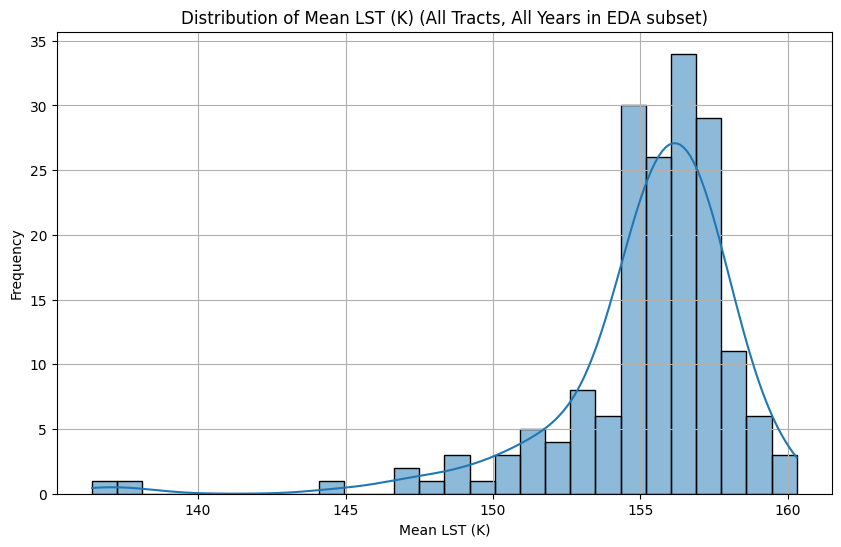

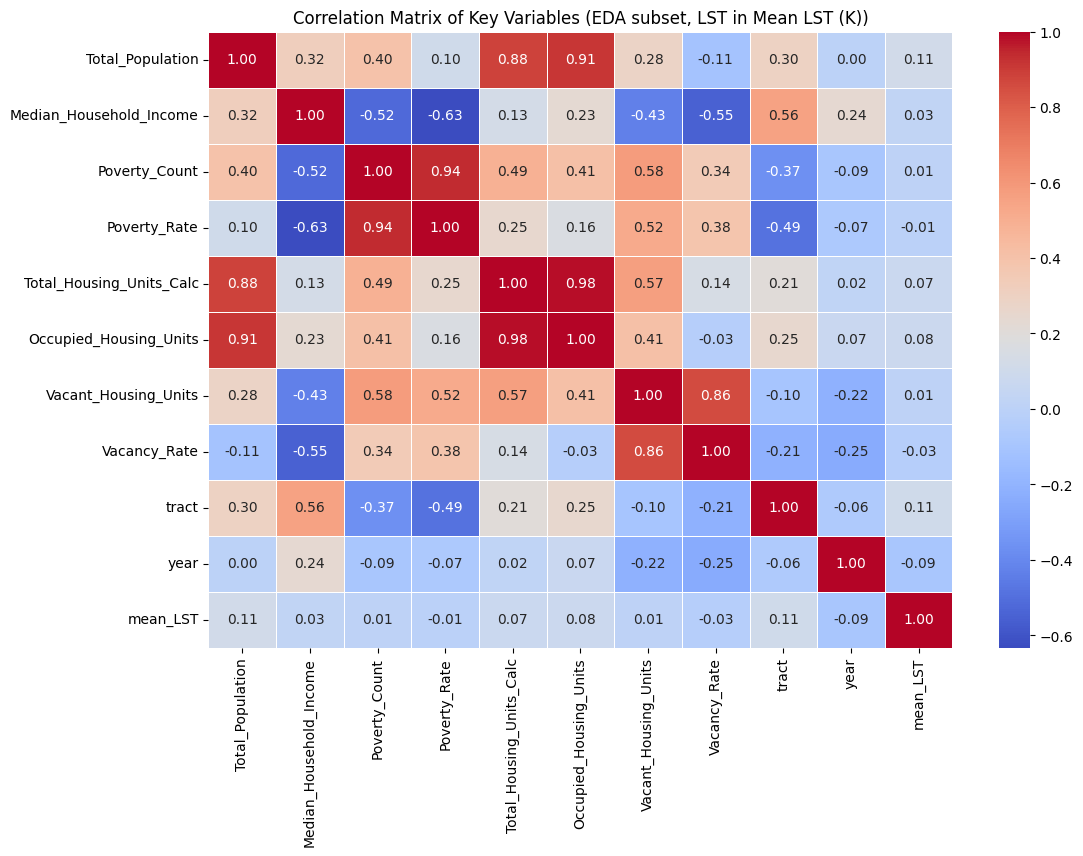

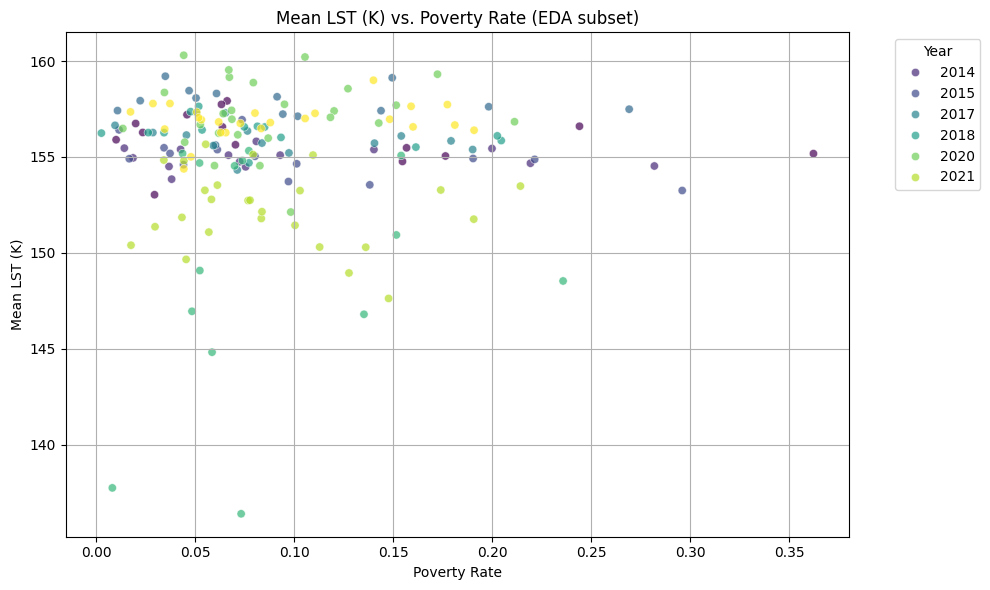

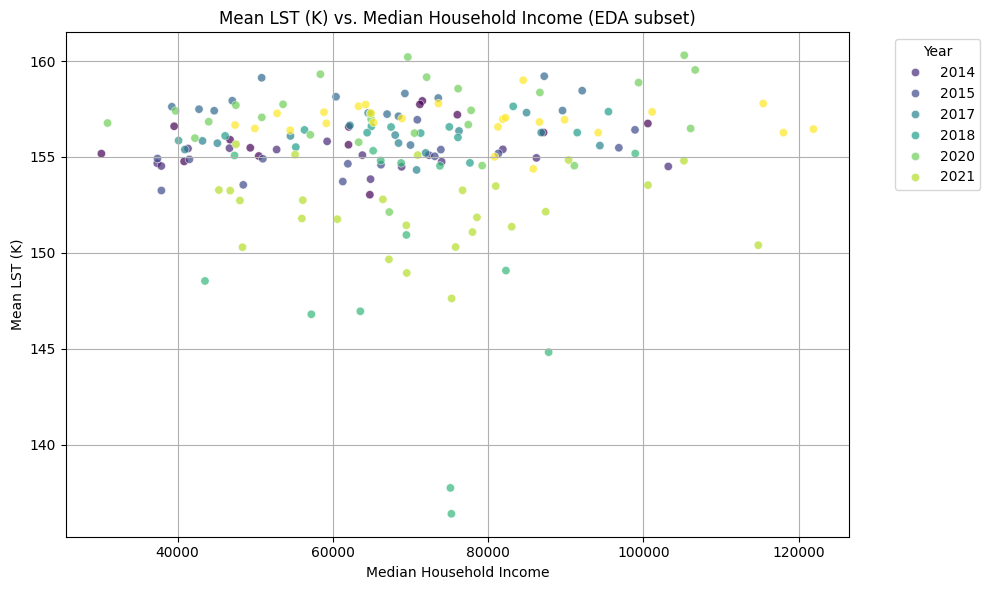

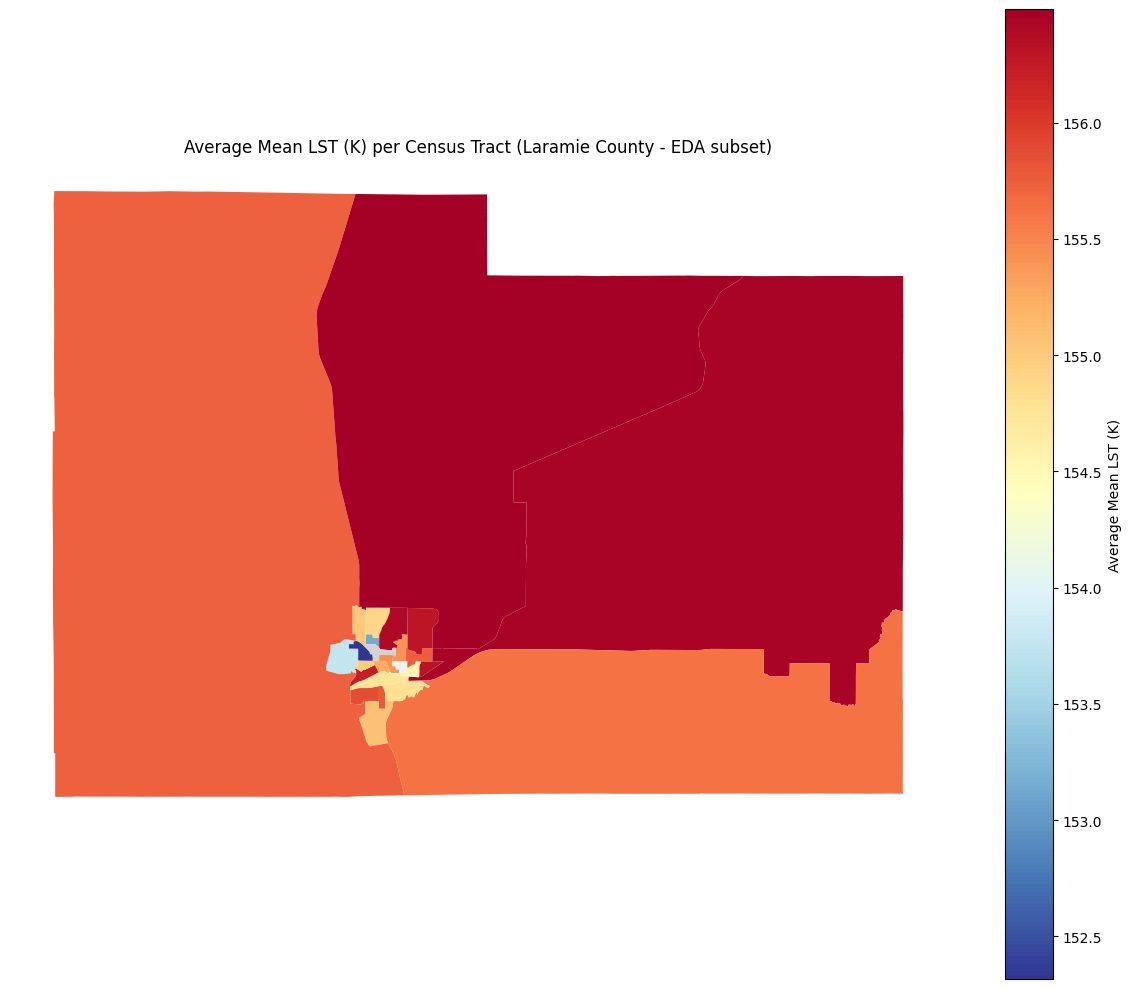


Cell 5: Finished EDA and Visualization.


In [7]:
# Cell 5: Exploratory Data Analysis (EDA) and Visualization (LST in Kelvin)


print("Cell 5: Starting Exploratory Data Analysis (EDA) and Visualization (LST in Kelvin).")

# Ensure df_analysis is available
if 'df_analysis' not in locals() or df_analysis.empty:
    print("ERROR: df_analysis DataFrame not found or empty.")
    print("Please ensure Cell 4 (Zonal Statistics) was run successfully.")
    df_analysis = pd.DataFrame(columns=['GEOID', 'year', 'mean_LST', 'Poverty_Rate', 'Median_Household_Income']) 
if 'gdf_laramie_tracts' not in locals() or gdf_laramie_tracts.empty:
    print("ERROR: gdf_laramie_tracts GeoDataFrame not found. Needed for mapping.")
    gdf_laramie_tracts = gpd.GeoDataFrame(columns=['GEOID', 'geometry'])

# --- 0. Setup LST column for EDA (Using original Kelvin values) ---
df_eda = df_analysis.copy() # Work with a copy for EDA
if 'mean_LST' in df_eda.columns:
    print(f"Using 'mean_LST' (Kelvin) for EDA. Original NaNs: {df_eda['mean_LST'].isna().sum()}")
    lst_column_for_eda = 'mean_LST'
    lst_axis_label = 'Mean LST (K)'
else:
    print("Warning: 'mean_LST' column not found. Cannot perform LST-related EDA.")
    df_eda['mean_LST'] = np.nan # Create a dummy column to prevent errors
    lst_column_for_eda = 'mean_LST' 
    lst_axis_label = 'Mean LST (Data Missing)'


# --- 1. Handle Missing Values for EDA ---
key_vars_for_eda = [lst_column_for_eda, 'Poverty_Rate', 'Median_Household_Income', 'Vacancy_Rate', 'Total_Population']
rows_before_dropna = len(df_eda)
# Drop rows where ANY of these key variables for EDA are NaN
df_eda.dropna(subset=key_vars_for_eda, inplace=True)
rows_after_dropna = len(df_eda)
print(f"Dropped {rows_before_dropna - rows_after_dropna} rows with NaNs in key EDA variables for plotting.")
print(f"Shape of df_eda for plotting: {df_eda.shape}")

if not df_eda.empty and lst_column_for_eda in df_eda.columns and not df_eda[lst_column_for_eda].isna().all():
    # --- 2. Descriptive Statistics of Key Variables ---
    print(f"\n--- Descriptive Statistics for Key Variables (EDA subset, LST in {lst_axis_label}) ---")
    print(df_eda[key_vars_for_eda].describe())

    # --- 3. Distribution of Mean LST (Kelvin) ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df_eda[lst_column_for_eda], kde=True)
    plt.title(f'Distribution of {lst_axis_label} (All Tracts, All Years in EDA subset)')
    plt.xlabel(lst_axis_label)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # --- 4. Correlation Heatmap ---
    plt.figure(figsize=(12, 8))
    numeric_cols_for_corr = df_eda.select_dtypes(include=np.number).columns.tolist()
    if 'GEOID' in numeric_cols_for_corr and pd.api.types.is_string_dtype(df_analysis['GEOID']): 
         if 'GEOID' in numeric_cols_for_corr: numeric_cols_for_corr.remove('GEOID')
    
    correlation_matrix = df_eda[numeric_cols_for_corr].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix of Key Variables (EDA subset, LST in {lst_axis_label})')
    plt.show()

    # --- 5. Scatter Plot: LST (Kelvin) vs. Poverty Rate ---
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_eda, x='Poverty_Rate', y=lst_column_for_eda, hue='year', palette='viridis', alpha=0.7)
    plt.title(f'{lst_axis_label} vs. Poverty Rate (EDA subset)')
    plt.xlabel('Poverty Rate')
    plt.ylabel(lst_axis_label)
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # --- 6. Scatter Plot: LST (Kelvin) vs. Median Household Income ---
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_eda, x='Median_Household_Income', y=lst_column_for_eda, hue='year', palette='viridis', alpha=0.7)
    plt.title(f'{lst_axis_label} vs. Median Household Income (EDA subset)')
    plt.xlabel('Median Household Income')
    plt.ylabel(lst_axis_label)
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- 7. Map of Average LST (Kelvin) per Tract ---
    if not gdf_laramie_tracts.empty and 'GEOID' in gdf_laramie_tracts.columns:
        avg_lst_per_tract = df_eda.groupby('GEOID')[lst_column_for_eda].mean().reset_index()
        
        gdf_laramie_tracts['GEOID'] = gdf_laramie_tracts['GEOID'].astype(str)
        avg_lst_per_tract['GEOID'] = avg_lst_per_tract['GEOID'].astype(str)
        
        map_data = gdf_laramie_tracts.merge(avg_lst_per_tract, on='GEOID', how='left')
        
        if not map_data[lst_column_for_eda].isna().all():
            fig, ax = plt.subplots(1, 1, figsize=(12, 10))
            map_data.plot(column=lst_column_for_eda, ax=ax, legend=True, cmap='RdYlBu_r', 
                          legend_kwds={'label': f"Average {lst_axis_label}"},
                          missing_kwds={"color": "lightgrey", "label": "Missing data"})
            ax.set_title(f'Average {lst_axis_label} per Census Tract (Laramie County - EDA subset)')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not generate LST map: No {lst_column_for_eda} data available after merging for map or all values are NaN.")
    else:
        print("Skipping map visualization: gdf_laramie_tracts is empty or missing GEOID.")
else:
    print("Skipping EDA plots as df_eda is empty after dropping NaNs or LST data is missing/all NaN.")

print("\nCell 5: Finished EDA and Visualization.")

In [8]:
# Cell 6: Statistical Modeling (OLS with Year Fixed Effects)


print("Cell 6: Starting Statistical Modeling.")

# Ensure df_analysis is available from Cell 4
if 'df_analysis' not in locals() or df_analysis.empty:
    print("ERROR: df_analysis DataFrame not found or empty.")
    print("Please ensure Cell 4 (Zonal Statistics & Merge) was run successfully.")
    # Create a dummy to prevent immediate crash, but cell won't work
    df_analysis = pd.DataFrame() 

# --- 1. Prepare Data for Modeling ---
if not df_analysis.empty:
    df_model = df_analysis.copy()

    # Define dependent and independent variables
    # Using LST in Kelvin as per your preference
    dependent_var = 'mean_LST' 
    
    # Choose socio-economic predictors.
    # These are common choices; you can adjust this list based on your hypotheses or EDA.
    independent_vars = [
        'Poverty_Rate', 
        'Median_Household_Income', 
        'Total_Population', 
        'Vacancy_Rate'
    ]
    
    # Variables needed for the model formula (including year for fixed effects)
    model_vars = [dependent_var] + independent_vars + ['year']
    
    # Check if all selected variables exist in the DataFrame
    missing_cols = [col for col in model_vars if col not in df_model.columns]
    if missing_cols:
        print(f"ERROR: The following columns required for the model are missing: {missing_cols}")
        print("Skipping model fitting.")
        model_fit = None # Ensure model_fit is defined for later checks
    else:
        # Handle missing values specifically for the model variables
        # Drop rows where ANY of the chosen model variables are NaN
        rows_before_model_dropna = len(df_model)
        df_model.dropna(subset=model_vars, inplace=True)
        rows_after_model_dropna = len(df_model)
        print(f"Original rows in df_analysis: {len(df_analysis)}")
        print(f"Rows before dropping NaNs for model: {rows_before_model_dropna}")
        print(f"Dropped {rows_before_model_dropna - rows_after_model_dropna} rows with NaNs in model variables.")
        print(f"Number of observations for modeling: {rows_after_model_dropna}")

        if rows_after_model_dropna < (len(independent_vars) + df_model['year'].nunique()): # Check for enough data
            print("Warning: Not enough data points after dropping NaNs to reliably fit the model with year dummies.")
            print("Consider using fewer predictors or a different NaN handling strategy if this is too low.")
            model_fit = None
        elif rows_after_model_dropna > 0 :
            # --- 2. Define and Fit the OLS Model ---
            # use C(year) to treat 'year' as a categorical variable (creating year dummies)
            # This implements year fixed effects.
            formula_terms = " + ".join(independent_vars)
            model_formula = f"{dependent_var} ~ {formula_terms} + C(year)"
            
            print(f"\nUsing OLS model formula: {model_formula}")
            
            try:
                ols_model = smf.ols(formula=model_formula, data=df_model)
                model_fit = ols_model.fit()
                
                # --- 3. View and Interpret Results ---
                print("\n--- OLS Model Summary ---")
                print(model_fit.summary())
                
                print("\n--- Brief Interpretation Notes ---")
                print("- R-squared: Proportion of variance in mean_LST explained by the model.")
                print("- Adj. R-squared: R-squared adjusted for the number of predictors.")
                print("- Coef: The estimated change in mean_LST for a one-unit increase in the predictor, holding other variables constant.")
                print("  - For C(year)[T.YYYY]: The average difference in mean_LST for year YYYY compared to the base year (the first year, by default), ceteris paribus.")
                print("- P>|t| (p-value): If < 0.05 (typically), the coefficient is statistically significantly different from zero.")
                print("- [0.025 0.975]: The 95% confidence interval for the coefficient.")
                
            except Exception as e:
                print(f"Error during model fitting or summary generation: {e}")
                model_fit = None
        else:
            print("No data available for modeling after dropping NaNs.")
            model_fit = None
else:
    print("Skipping modeling as df_analysis is empty.")
    model_fit = None # Ensure model_fit is defined

if 'model_fit' not in locals() or model_fit is None:
     print("\nModel was not successfully fitted. Please check previous error messages.")

print("\nCell 6: Finished Statistical Modeling.")

Cell 6: Starting Statistical Modeling.
Original rows in df_analysis: 228
Rows before dropping NaNs for model: 228
Dropped 53 rows with NaNs in model variables.
Number of observations for modeling: 175

Using OLS model formula: mean_LST ~ Poverty_Rate + Median_Household_Income + Total_Population + Vacancy_Rate + C(year)

--- OLS Model Summary ---
                            OLS Regression Results                            
Dep. Variable:               mean_LST   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     16.93
Date:                Fri, 09 May 2025   Prob (F-statistic):           5.00e-24
Time:                        21:29:19   Log-Likelihood:                -377.11
No. Observations:                 175   AIC:                             782.2
Df Residuals:                     161   BIC:                             826.5
Df Model:           

Cell 7: Investigating Multicollinearity and Refining Predictors.
Number of observations after NaN dropping for correlation check: 175

--- Correlation Matrix of Socio-Economic Predictors ---


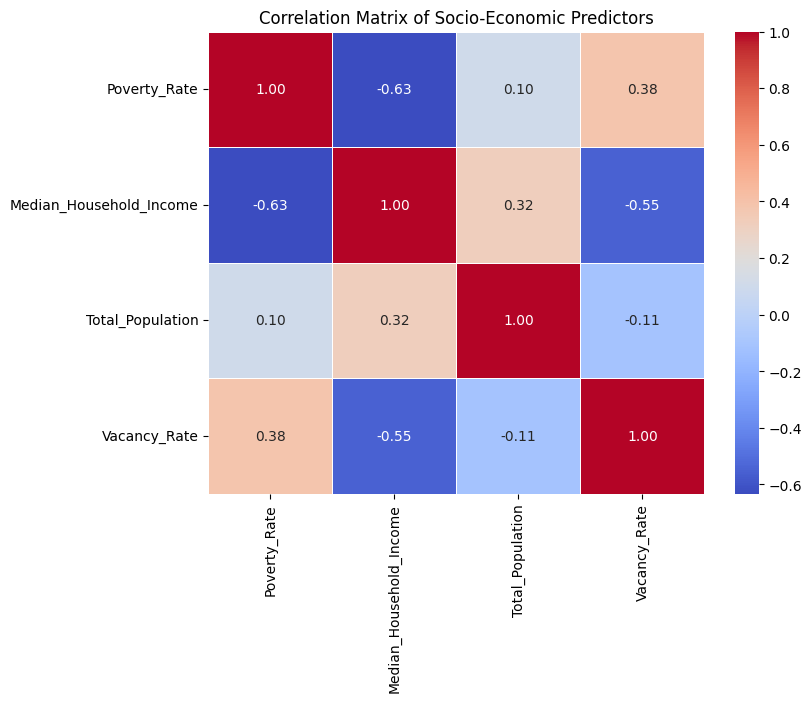


Interpreting the correlation matrix:
- Values close to 1 or -1 indicate strong linear correlation.
- High correlation (e.g., > 0.7 or < -0.7) between predictors can lead to multicollinearity.

Correlation between Poverty_Rate and Median_Household_Income: -0.63
  This correlation is notable. Given previous p-values, consider removing one.
  Decision: Attempting to remove 'Median_Household_Income' from predictors for the refined model.

Refined set of socio-economic predictors: ['Poverty_Rate', 'Total_Population', 'Vacancy_Rate']

Using REFINED OLS model formula: mean_LST ~ Poverty_Rate + Total_Population + Vacancy_Rate + C(year)

--- REFINED OLS Model Summary ---
                            OLS Regression Results                            
Dep. Variable:               mean_LST   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     18.25
Date:       

In [9]:
# Cell 7: Investigate Multicollinearity and Refine Predictors

print("Cell 7: Investigating Multicollinearity and Refining Predictors.")

# Ensure df_analysis is available (as model_fit depends on df_model from df_analysis)
if 'df_analysis' not in locals() or df_analysis.empty:
    print("ERROR: df_analysis DataFrame not found or empty.")
    print("Please ensure Cell 4 (Zonal Statistics & Merge) was run successfully.")
    df_analysis = pd.DataFrame() # Dummy to prevent crash

# Re-create df_model to ensure we're using the same base as Cell 6's model
if not df_analysis.empty:
    df_model_for_corr = df_analysis.copy()
    
    # Variables used in the previous model (socio-economic ones for correlation check)
    socio_economic_vars = [
        'Poverty_Rate', 
        'Median_Household_Income', 
        'Total_Population',
        'Vacancy_Rate'
    ]
    dependent_var = 'mean_LST' # LST in Kelvin
    
    # Also need 'year' for the final model, and dependent_var for consistent NaN dropping
    vars_for_nan_dropping = [dependent_var] + socio_economic_vars + ['year']
    
    # Check if all selected variables exist in the DataFrame
    missing_cols_corr = [col for col in vars_for_nan_dropping if col not in df_model_for_corr.columns]
    if missing_cols_corr:
        print(f"ERROR: The following columns required for correlation/model are missing: {missing_cols_corr}")
        model_fit_refined = None
    else:
        # Drop NaNs consistently for the set of variables we'll be working with
        df_model_for_corr.dropna(subset=vars_for_nan_dropping, inplace=True)
        print(f"Number of observations after NaN dropping for correlation check: {len(df_model_for_corr)}")

        if not df_model_for_corr.empty and len(df_model_for_corr) > 1: # Need at least 2 rows for correlation
            # --- 1. Correlation Matrix of Socio-Economic Predictors ---
            print("\n--- Correlation Matrix of Socio-Economic Predictors ---")
            correlation_matrix_predictors = df_model_for_corr[socio_economic_vars].corr()
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(correlation_matrix_predictors, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
            plt.title('Correlation Matrix of Socio-Economic Predictors')
            plt.show()
            
            print("\nInterpreting the correlation matrix:")
            print("- Values close to 1 or -1 indicate strong linear correlation.")
            print("- High correlation (e.g., > 0.7 or < -0.7) between predictors can lead to multicollinearity.")

            # --- 2. Decide on Predictor Refinement (Example Strategy) ---
            # Based on Cell 6: Median_Household_Income and Poverty_Rate were not significant.
            # Let's check their correlation. If high, we might drop one.
            # Let's also consider if Total_Population and Vacancy_Rate have very high correlation.
            
            refined_independent_vars = socio_economic_vars.copy() # Start with all
            
            # Example: If Poverty_Rate and Median_Household_Income are highly correlated,
            # and Median_Household_Income had a higher p-value (less significant) in Cell 6,
            # we might try removing Median_Household_Income.
            if 'Poverty_Rate' in refined_independent_vars and 'Median_Household_Income' in refined_independent_vars:
                corr_pov_inc = correlation_matrix_predictors.loc['Poverty_Rate', 'Median_Household_Income']
                print(f"\nCorrelation between Poverty_Rate and Median_Household_Income: {corr_pov_inc:.2f}")
                if abs(corr_pov_inc) > 0.5: # Threshold for "high enough to consider"
                    print("  This correlation is notable. Given previous p-values, consider removing one.")
                    # Decision: Let's try removing Median_Household_Income as it had a high p-value and is often correlated with poverty.
                    # Also, Poverty_Rate might be a more direct measure of vulnerability.
                    if 'Median_Household_Income' in refined_independent_vars:
                         print("  Decision: Attempting to remove 'Median_Household_Income' from predictors for the refined model.")
                         refined_independent_vars.remove('Median_Household_Income')
                    else:
                         print("  'Median_Household_Income' not in list to remove, perhaps already removed or typo.")

            # You can add more sophisticated logic here, e.g., using Variance Inflation Factor (VIF)
            # For now, this is a heuristic based on correlation and previous model's p-values.

            print(f"\nRefined set of socio-economic predictors: {refined_independent_vars}")

            # --- 3. Re-run OLS Model with Refined Predictors ---
            if not refined_independent_vars:
                print("No independent variables left after refinement. Cannot run model.")
                model_fit_refined = None
            else:
                formula_terms_refined = " + ".join(refined_independent_vars)
                model_formula_refined = f"{dependent_var} ~ {formula_terms_refined} + C(year)"
                
                print(f"\nUsing REFINED OLS model formula: {model_formula_refined}")
                
                # Ensure enough data points for the refined model
                min_obs_needed = len(refined_independent_vars) + df_model_for_corr['year'].nunique()
                if len(df_model_for_corr) < min_obs_needed:
                    print(f"Warning: Not enough data points ({len(df_model_for_corr)}) for the refined model (needs at least {min_obs_needed}).")
                    model_fit_refined = None
                else:
                    try:
                        ols_model_refined = smf.ols(formula=model_formula_refined, data=df_model_for_corr)
                        model_fit_refined = ols_model_refined.fit()
                        
                        print("\n--- REFINED OLS Model Summary ---")
                        print(model_fit_refined.summary())
                        
                        # Check condition number again
                        print(f"\nCondition Number for refined model: {model_fit_refined.condition_number:.2e}")
                        if model_fit_refined.condition_number > 30: # A common threshold for concern
                             print("  Warning: Condition number is still somewhat high.")
                        else:
                             print("  Condition number looks improved.")

                    except Exception as e:
                        print(f"Error during refined model fitting or summary generation: {e}")
                        model_fit_refined = None
        else:
            print("Not enough data after NaN dropping to calculate predictor correlations or fit model.")
            model_fit_refined = None
else:
    print("Skipping Cell 7 as df_analysis is empty.")
    model_fit_refined = None

if 'model_fit_refined' not in locals() or model_fit_refined is None:
     print("\nRefined model was not successfully fitted. Please check previous error messages.")

print("\nCell 7: Finished Investigating Multicollinearity and Refining Predictors.")